In [ ]:
nome = 'Matheus Lindino'
print(f'Meu nome é {nome}')

Meu nome é Matheus Lindino


#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural similar a do Bengio 2003 para prever a próxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Linguagem".

Algumas dicas:
- Inclua caracteres de pontuação (ex: `.` e `,`) no vocabulário.
- Deixe tudo como caixa baixa (lower-case).
- A escolha do tamanho do vocabulario é importante: ser for muito grande, fica difícil para o modelo aprender boas representações. Se for muito pequeno, o modelo apenas conseguirá gerar textos simples.
- Remova qualquer exemplo de treino/validação/teste que tenha pelo menos um token desconhecido (ou na entrada ou na saída). 
- Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

## Importação dos pacotes

In [ ]:
import collections
import itertools
import functools
import math
import os
import random
import re
import copy

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook
from typing import List

In [ ]:
# Check which GPU we are using
!nvidia-smi

Wed Sep 21 15:54:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Carregamento do dataset 

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



## Carregando o dataset

Criaremos uma divisão de treino (80%) e validação (20%) artificialmente.

Nota: Evitar de olhar ao máximo o dataset de teste para não ficar enviseado no que será testado. Em aplicações reais, o dataset de teste só estará disponível no futuro, ou seja, é quando o usuário começa a testar o seu produto.

In [ ]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
random.shuffle(x_train)

n_train = int(0.8 * len(x_train))

x_valid = x_train[n_train:]
x_train = x_train[:n_train]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x in x_train[:3]:
    print(x[:100])

print('3 últimas amostras treino:')
for x in x_train[-3:]:
    print(x[:100])

print('3 primeiras amostras validação:')
for x in x_valid[:3]:
    print(x[:100])

print('3 últimas amostras validação:')
for x in x_valid[-3:]:
    print(x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
Some wonder why there weren't anymore Mrs. Murphy movies after this one. Will it's because this movi
Blood Castle (aka Scream of the Demon Lover, Altar of Blood, Ivanna--the best, but least exploitatio
"Dominique" is one of those films that the expression "slow-as-molasses" must have been invented for
3 últimas amostras treino:
A lot of the user comments i have seen on the IMDB for this movie don't really do it justice. First 
I almost didn't rent this because of all the bad comments but did anyways.I thought it was similar t
I had a really hard time making it through this move. It was extermly slow and at times wondered whe
3 primeiras amostras validação:
A tour deforce! OK the kid that plays Oliver is a bit toooooo sweet! Starting with the great cinemat
This film is a perfect example of the recent crop of horror films that simply are not fully realized
This is an installm

## Classe Tokenizer

In [ ]:
class Tokenizer():
  def __init__(self, max_tokens=3000):
    self.max_tokens_ = max_tokens
    self.vocab_ = None

  def tokenize(self, text: str):
    pattern = r'\w+|[^\w\s]'
    text = text.replace('<br />',' ')
    return [tokens.lower() for tokens in re.findall(pattern, text)]

  def create_vocab(self, texts: List[str]):
    tokens = self.tokenize(' '.join(texts))
    counter = collections.Counter(tokens).most_common(self.max_tokens_)
    self.vocab_ = dict((key, i) for i, (key, values) in enumerate(counter))
    self.vocab_['unk'] = -1
    
    return self

  def encode(self, data: str):
    data = self.tokenize(data)
    return [self.vocab_.get(sample, -1) for sample in data]
  
  def decode(self, array):
    inverse_vocab = {y: x for x, y in self.vocab_.items()}
    return [inverse_vocab[i] for i in array]

### Asserts da tokenização e codificação

In [ ]:
corpus = ['Apple, Banana, Apple, Avocado, Pineapple <br /><br />',
          'Apple. Pineapple and Mango',
          'Banana, Mango! Banana, Apple',
          'Pineapple Berry Apricot Apple',
          'Avocado Apple']
            
sample = 'Apricot Apple, Banana, Banana Banana'


tokenizer = Tokenizer(max_tokens=3)
tokenizer.create_vocab(corpus)
vocab = tokenizer.vocab_
encoded = tokenizer.encode(sample)
decoded = tokenizer.decode(encoded)

assert list(vocab.keys()) == ['apple', ',', 'banana', 'unk'], 'Vocab Incorrect'
assert encoded == [-1, 0, 1, 2, 1, 2, 2], 'Encoder Incorrect'
assert decoded == ['unk', 'apple', ',', 'banana', ',', 'banana', 'banana'], 'Decoder Incorrect'

## Dataset

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, n_context=9):
        super().__init__()
        self.data = []
              
        for sample in data:
          sample = tokenizer.encode(sample)
          
          for i in range(0, len(sample) - n_context):
            sample_sliced = sample[i:i+n_context+1]
            
            if -1 not in sample_sliced:
              self.data.append(sample_sliced) 

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return torch.tensor(self.data[index][:-1]), torch.tensor(self.data[index][-1]).long()

### Asserts do Dataset

In [ ]:
corpus = ['Apple, Banana, Apple, Avocado, Pineapple',
          'Apple. Pineapple and Mango',
          'Banana, Mango! Banana, Apple',
          'Pineapple Berry Apricot Apple',
          'Avocado Apple']

n_context = 2
customDataset = IMDBDataset(data=corpus, tokenizer=Tokenizer(max_tokens=3).create_vocab(corpus), n_context=n_context)
x, y = customDataset.__getitem__(0)

assert len(customDataset.data[0]) == n_context+1, 'Dataset shape incorrect'
assert x.shape[0] == n_context, 'Example shape incorrect'

## Modelo de Linguagem

In [ ]:
class BasicLanguageModel(nn.Module):
  def __init__(self, n_context, vocab_size, embedding_dim, hidden_size):
    super().__init__()
    self.embedding   = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, max_norm=True)
    self.input_layer = nn.Linear(in_features=n_context*embedding_dim, out_features=hidden_size)
    self.activation  = nn.ReLU()
    self.out_layer   = nn.Linear(in_features=hidden_size, out_features=vocab_size)

  def forward(self, data):
    data = self.embedding(data)
    data = self.input_layer(data.flatten(start_dim=1))
    data = self.activation(data)
    data = self.out_layer(data)

    return data

### Asserts do modelo

In [ ]:
batch_size = 2
n_context  = 10
vocab_size = 50

model = BasicLanguageModel(n_context=n_context, vocab_size=vocab_size, embedding_dim=10, hidden_size=10)
inputs = torch.rand((batch_size, n_context)).long()
logits = model(inputs)

assert list(logits.shape) == [batch_size, vocab_size], 'Logits shape incorrect'

## Early Stopping

In [ ]:
class EarlyStopping():
  def __init__(self, patience=10, min_delta=0):
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.best_model_wts = None
    self.min_delta = min_delta

  def __call__(self, model, val_loss):
    score = -val_loss

    if self.best_score is None:
        self.best_score = score
        self.best_model_wts = copy.deepcopy(model.state_dict())
        return False

    elif score < self.best_score + self.min_delta:
        self.counter += 1
        if self.counter >= self.patience:
            return True
    else:
        self.best_score = score
        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.counter = 0
        return False

## Funções auxiliares para treinamento

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, get_perplexity, initial_perplexity):
  running_loss = 0.0
  running_corrects = 0
  model.train()
  for inputs, targets in dataloader:    
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    initial_perplexity = np.exp(loss.item()) if get_perplexity  else initial_perplexity
    get_perplexity = False
    
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() 
    running_corrects += torch.sum(preds == targets.data)

  return running_loss, running_corrects, initial_perplexity

def evaluate(model, dataloader, criterion):
  running_loss = 0.0
  running_corrects = 0

  model.eval()
  for inputs, targets in dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      _, preds = torch.max(outputs, 1)
      
      running_loss += loss.item()
      running_corrects += torch.sum(preds == targets.data)

  return running_loss, running_corrects

## Hiper-Parametros

In [ ]:
params = {
  'n_context': 9,
  'vocab_size': 3000,
  'embedding_dim': 64,
  'hidden_size': 64,
  'batch_size': 256,
  'epochs': 50,
  'lr': 1e-3,
  'patience': 10,
  'min_delta':0
}

In [ ]:
tokenizer     = Tokenizer(max_tokens=params['vocab_size']).create_vocab(x_train)
train_dataset = IMDBDataset(data=x_train, tokenizer=tokenizer, n_context=params['n_context'])
val_dataset   = IMDBDataset(data=x_valid, tokenizer=tokenizer, n_context=params['n_context'])
test_dataset  = IMDBDataset(data=x_test, tokenizer=tokenizer, n_context=params['n_context'])

train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=params['batch_size'])
test_loader  = DataLoader(test_dataset, batch_size=params['batch_size'])

In [ ]:
model = BasicLanguageModel(n_context=params['n_context'], vocab_size=params['vocab_size'], embedding_dim=params['embedding_dim'], hidden_size=params['hidden_size'])
model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=params['patience'], min_delta=params['min_delta'])

history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[], 'train_perplexity': [], 'val_perplexity' : []}
initial_perplexity = 0.0

for epoch in tqdm(range(params['epochs'])):
  train_loss, train_correct, initial_perplexity = train_epoch(model=model, 
                                                              dataloader=train_loader, 
                                                              criterion=criterion, 
                                                              optimizer=optimizer,
                                                              get_perplexity=True if epoch == 0 else False,
                                                              initial_perplexity=initial_perplexity)

  val_loss, val_correct  = evaluate(model=model, 
                                    dataloader=val_loader,
                                    criterion=criterion)

  train_loss = train_loss / len(train_loader)
  train_acc = train_correct.cpu().item() / len(train_loader.sampler) * 100
  train_perplexity = np.exp(train_loss)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct.cpu().item() / len(val_loader.sampler) * 100
  val_perplexity = np.exp(val_loss)

  if early_stopping(model, val_loss): break

  #print(f'EPOCH: {epoch}\t---\tTRAIN LOSS: {round(train_loss, 3)}\t --- \tTRAIN PERPLEXITY: {round(train_perplexity, 3)}\t --- \tTRAIN ACC: {round(train_acc, 2)}\t --- \tVAL LOSS: {round(val_loss, 3)}\t --- \tVAL ACC: {round(val_acc, 2)}\t --- \tVAL PERPLEXITY: {round(val_perplexity, 3)} ')

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['train_perplexity'].append(train_perplexity)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)
  history['val_perplexity'].append(val_perplexity)

 84%|████████▍ | 42/50 [27:09<05:10, 38.81s/it]


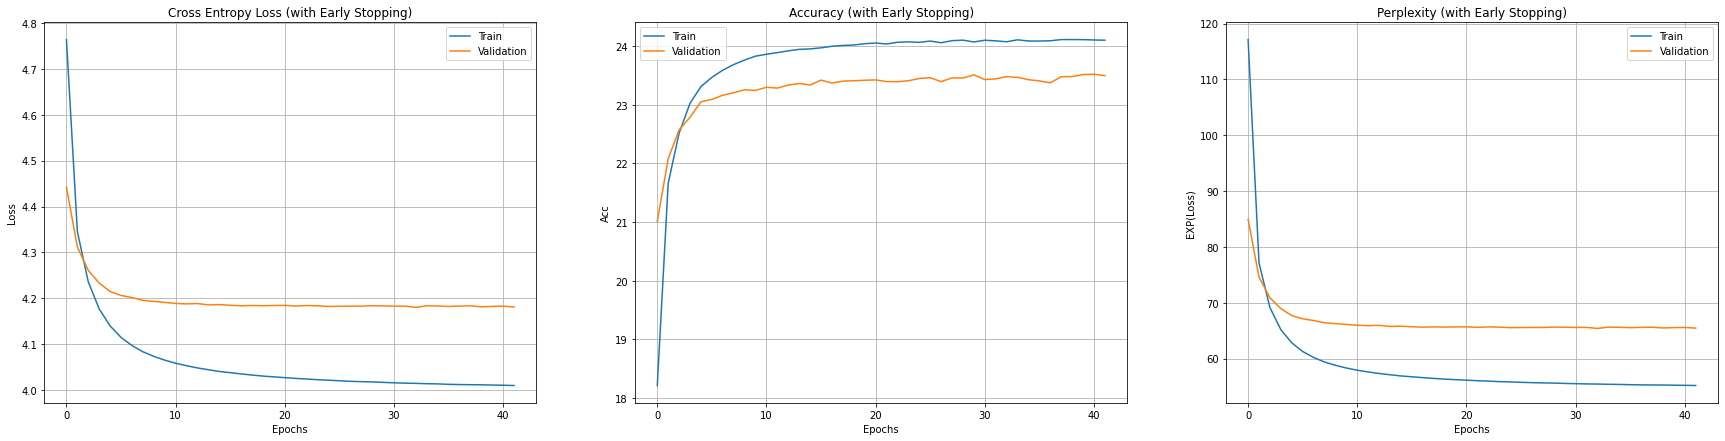

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(len(history['train_loss']))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,7))
axes[0].plot(epochs, history['train_loss'], label='Train')
axes[0].plot(epochs, history['val_loss'], label='Validation')
axes[0].set_title('Cross Entropy Loss (with Early Stopping)')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
axes[0].grid(); axes[0].legend()

axes[1].plot(epochs, history['train_acc'], label='Train')
axes[1].plot(epochs, history['val_acc'], label='Validation')
axes[1].set_title('Accuracy (with Early Stopping)')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Acc')
axes[1].grid(); axes[1].legend()

axes[2].plot(epochs, history['train_perplexity'], label='Train')
axes[2].plot(epochs, history['val_perplexity'], label='Validation')
axes[2].set_title('Perplexity (with Early Stopping)')
axes[2].set_xlabel('Epochs'); axes[2].set_ylabel('EXP(Loss)')
axes[2].grid(); axes[2].legend()

plt.show()

In [ ]:
model = BasicLanguageModel(n_context=params['n_context'], vocab_size=params['vocab_size'], embedding_dim=params['embedding_dim'], hidden_size=params['hidden_size'])
model.load_state_dict(early_stopping.best_model_wts)
model.to(device)

test_loss, test_correct  = evaluate(model=model, 
                                  dataloader=test_loader,
                                  criterion=criterion)

test_loss = test_loss / len(test_loader)
test_acc = test_correct.cpu().item() / len(test_loader.sampler) * 100
test_perplexity = np.exp(test_loss)

print(f'INITIAL PERPLEXITY: {initial_perplexity} ----- TEST LOSS: {test_loss} ----- TEST ACC: {test_acc} ----- TEST PERPLEXITY: {test_perplexity}')

INITIAL PERPLEXITY: 3032.6956173355693 ----- TEST LOSS: 4.181991795991177 ----- TEST ACC: 23.447065801610094 ----- TEST PERPLEXITY: 65.49617840591277


In [ ]:
text_sample = "Amazing movie, good writer, terrific actors and"

for i in range(13):
  vector_input = torch.Tensor(tokenizer.encode(text_sample)).long()
  vector_input = vector_input.reshape(1,-1).to(device)
  
  logits = model(vector_input[:, i:])
  _, preds = torch.max(logits, 1)

  vector_input = torch.cat((vector_input, preds.reshape(1,-1)), dim=1)
  text_sample = tokenizer.decode(vector_input.reshape(-1).cpu().numpy())
  text_sample = ' '.join(text_sample)

  print('Generated Text:', text_sample)

Generated Text: amazing movie , good writer , terrific actors and actresses
Generated Text: amazing movie , good writer , terrific actors and actresses ,
Generated Text: amazing movie , good writer , terrific actors and actresses , but
Generated Text: amazing movie , good writer , terrific actors and actresses , but the
Generated Text: amazing movie , good writer , terrific actors and actresses , but the script
Generated Text: amazing movie , good writer , terrific actors and actresses , but the script is
Generated Text: amazing movie , good writer , terrific actors and actresses , but the script is not
Generated Text: amazing movie , good writer , terrific actors and actresses , but the script is not as
Generated Text: amazing movie , good writer , terrific actors and actresses , but the script is not as good
Generated Text: amazing movie , good writer , terrific actors and actresses , but the script is not as good as
Generated Text: amazing movie , good writer , terrific actors and a

In [ ]:
text_sample = "Worst film ever. <br /><br /> Don't watch it <br /><br />"

for i in range(13):
  vector_input = torch.Tensor(tokenizer.encode(text_sample)).long()
  vector_input = vector_input.reshape(1,-1).to(device)
  
  logits = model(vector_input[:, i:])
  _, preds = torch.max(logits, 1)

  vector_input = torch.cat((vector_input, preds.reshape(1,-1)), dim=1)
  text_sample = tokenizer.decode(vector_input.reshape(-1).cpu().numpy())
  text_sample = ' '.join(text_sample)

  print('Generated Text:', text_sample)

Generated Text: worst film ever . don ' t watch it .
Generated Text: worst film ever . don ' t watch it . i
Generated Text: worst film ever . don ' t watch it . i '
Generated Text: worst film ever . don ' t watch it . i ' m
Generated Text: worst film ever . don ' t watch it . i ' m not
Generated Text: worst film ever . don ' t watch it . i ' m not sure
Generated Text: worst film ever . don ' t watch it . i ' m not sure what
Generated Text: worst film ever . don ' t watch it . i ' m not sure what it
Generated Text: worst film ever . don ' t watch it . i ' m not sure what it was
Generated Text: worst film ever . don ' t watch it . i ' m not sure what it was going
Generated Text: worst film ever . don ' t watch it . i ' m not sure what it was going to
Generated Text: worst film ever . don ' t watch it . i ' m not sure what it was going to happen
Generated Text: worst film ever . don ' t watch it . i ' m not sure what it was going to happen .
